In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

In [330]:
from tqdm import tqdm
import inspect
import warnings
warnings.filterwarnings("ignore") 

In [306]:
def roundf(val):
    precision = 3
    
    if isinstance(val, tuple):
        return (round(float(val[0]), precision), round(float(val[1]), precision))
    else:
        return round(val, precision)

In [307]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [308]:
def encode(df):
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    encoder = OneHotEncoder(sparse=False)
    one_hot_encoded = encoder.fit_transform(df[categorical_columns])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
    df_encoded = pd.concat([df, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(categorical_columns, axis=1)
    
    return df_encoded

In [309]:
def calc_metrics(model, X, y, test=False, output=True):    
    metric_names = ['Accuracy', 'BA', 'Precision', 'Recall', 'F1 score', 'MCC']

    accuracy = roundf(metrics.accuracy_score(y, model.predict(X)))
    BA = roundf(metrics.balanced_accuracy_score(y, model.predict(X)))
    precision = roundf(metrics.precision_score(y, model.predict(X), average='weighted'))
    recall = roundf(metrics.recall_score(y, model.predict(X), average='weighted'))
    F1_score = roundf(metrics.f1_score(y, model.predict(X), average='weighted'))
    MCC = roundf(metrics.matthews_corrcoef(y, model.predict(X)))
    
    lst = [(retrieve_name(accuracy)[0], accuracy), 
           (retrieve_name(BA)[0], BA),
           (retrieve_name(precision)[0], precision),
           (retrieve_name(recall)[0], recall),
           (retrieve_name(F1_score)[0], F1_score),
           (retrieve_name(MCC)[0], MCC)]
    
    if output:
        print(f"Вибірка - {'test' if test else 'train'}")
        for el in lst:
            print(f' {el[0]}: {el[1]}')
    
    return ([accuracy, BA, precision, recall, F1_score, MCC], [el[0] for el in lst])

In [310]:
def plot_metrics(values, labels, title):
    bar_width = 0.35

    index = np.arange(len(values))

    subplots = 1
    fig, axs = plt.subplots(subplots, 1, figsize=(12, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, len(values)))

    bars = axs.bar(index, values, bar_width, label=labels)

    for i, bar in enumerate(bars):
        bar.set_color(colors[i])

    axs.set_ylabel('Values')
    axs.set_title(title)
    axs.set_xticks(index)
    axs.set_xticklabels(labels, rotation=45)
    axs.set_yticks(np.linspace(0, 1, 11))

    plt.tight_layout()
    plt.show()

In [347]:
def plot_results(set1, set2, labels, title):
    num_plots = len(labels)
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

    for i in range(num_plots):
        axs[0].plot([sublist[i] for sublist in set1], label=labels[i], color=colors[i])
        axs[1].plot([sublist[i] for sublist in set2], label=labels[i], color=colors[i])

    axs[0].set_title('Train')
    axs[1].set_title('Test')
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(title)

    for ax in axs:
        ax.set_xticks(range(0, 20, 1))  # Adjusted to start from 0
        ax.set_xticklabels(range(1, 21, 1))  # Adjusted labels

    plt.show()

### 1. Відкрити та зчитати наданий файл з даними.

In [311]:
df = pd.read_csv('dataset3_l4.csv')

In [312]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


### 2. Визначити та вивести кількість записів.

In [313]:
print(f'Кількість записів: {len(df)}')

Кількість записів: 2111


### 3. Вивести атрибути набору даних.

In [314]:
print(*df.columns.values, sep='\n')

Gender
Age
Height
Weight
family_history_with_overweight
FAVC
FCVC
NCP
CAEC
SMOKE
CH2O
SCC
FAF
TUE
CALC
MTRANS
NObeyesdad


### 4.
- ввести з клавіатури кількість варіантів перемішування (не менше трьох)
- отримати відповідну кількість варіантів перемішування набору даних та розділення його на навчальну (тренувальну) та тестову вибірки, використовуючи функцію ***ShuffleSplit***
- сформувати навчальну та тестову вибірки на основі другого варіанту
- з'ясувати збалансованість набору даних

Вводимо кількість варіантів перемішування

In [315]:
n = int(input('Введіть кількість варіантів перемішування (≥3): '))

Розбиття на навчальну та тестову вибірки виконуватимемо у відношенні 3 до 1:

In [316]:
rs = ShuffleSplit(n_splits=n, test_size=.25, random_state=0)
print(rs)

ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None)


In [317]:
np.set_printoptions(threshold=9)

*(Передаючи pandas DataFrame у функцію ShuffleSplit на вихід отримуватимемо список індексів з початкового датафрейму, за якими вже можна буде звертатись до конкретних записів (рядків даних))*

In [318]:
option = 2

In [319]:
for i, (train_index, test_index) in enumerate(rs.split(df), start=1):
    print(f"Варіант перемішування {i}:")
    print(f"  Train: {train_index}, length={len(train_index)}")
    print(f"  Test:  {test_index}, length={len(test_index)}\n")
    
    if i == option - 1:
        train, test = train_index, test_index

Варіант перемішування 1:
  Train: [2075  113 1140 ...  763  835 1653], length=1583
  Test:  [1730  259  966 ... 1396 1948 1670], length=528

Варіант перемішування 2:
  Train: [ 983 1492 1811 ... 2086 1454   55], length=1583
  Test:  [ 617 1714  484 ...  576 1487 1447], length=528

Варіант перемішування 3:
  Train: [ 111  401  594 ... 1349  309  984], length=1583
  Test:  [ 844  864 1658 ...   72 1386  934], length=528

Варіант перемішування 4:
  Train: [1077  638 1542 ... 1522  436  956], length=1583
  Test:  [ 927  722 1859 ... 1932 1172 1904], length=528

Варіант перемішування 5:
  Train: [1858  190 1635 ...  867  147  926], length=1583
  Test:  [1108   39  528 ...  411  862  562], length=528



З'ясуємо збалансованість набору даних. Як можна побачити з назв атрибутів, у датасеті надається інформація про конкретних осіб (їх вік, зріст тощо), яких можна чітко поділити за атрибутом ***Gender***:

In [320]:
count = df['Gender'].value_counts()

In [321]:
for i in range(len(count)):
    print(f'Частка {count.index[i]}: {round(count.values[i] * 100 / len(df), 2)}%')

Частка Male: 50.59%
Частка Female: 49.41%


Як бачимо, набір даних є збалансованим.

### 5.
- використовуючи функцію ***KNeighborsClassifier*** бібліотеки ***scikit-learn***, збудувати класифікаційну модель на основі методу *k* найближчих сусідів (значення всіх параметрів залишити за замовчуванням);
- навчити її на тренувальній вибірці, вважаючи, що цільова характеристика визначається стовпчиком ***NObeyesdad***, а всі інші виступають в ролі вихідних аргументів.

Будуємо класифікаційну модель зі значеннями за замовчуванням:

In [322]:
neigh = KNeighborsClassifier()

Оскільки набір даних складається з mixed data (містить як числові, так і рядкові значення), то для того, щоб навчити модель на тренувальній вибірці, string data необхідно перевести до числових категоріальних змінних. Оскільки бездумне кодування категорій від 0 до m може привести до того, що змінні, які не можна однозначно впорядкувати за значимістю (наприклад, кольори), за відстанню будуть знаходитись не один біля одного, то для кодування скористаємось [OneHotEncoder](https://www.geeksforgeeks.org/ml-one-hot-encoding/)'ом. Невеличкий приклад його роботи можна переглянути за [посиланням](https://qr.ae/ps5AS7). Окрім того очевидно, що оскільки mixed data міститься лиш у вхідних даних, то target class кодувати не потрібно.

In [323]:
X_train = encode(df).iloc[train, :-1]
y_train = df.iloc[train, -1]

X_test = encode(df).iloc[test, :-1]
y_test = df.iloc[test, -1]

neigh.fit(X_train, y_train)

print(f'Прогноз моделі: {neigh.predict(X_test)}\n')

Прогноз моделі: ['Obesity_Type_II' 'Obesity_Type_I' 'Overweight_Level_I' ...
 'Obesity_Type_I' 'Obesity_Type_III' 'Obesity_Type_II']



### 6. 
- обчислити класифікаційні метрики збудованої моделі для тренувальної та тестової вибірки;
- представити результати роботи моделі на тестовій вибірці графічно.

Класифікаційні метрики збудованої моделі для тренувальної та тестової вибірки:

In [324]:
train_metrics, _ = calc_metrics(neigh, X_train, y_train, test=False)

Вибірка - train
 accuracy: 0.949
 BA: 0.948
 precision: 0.95
 recall: 0.949
 F1_score: 0.948
 MCC: 0.941


In [325]:
test_metrics, names = calc_metrics(neigh, X_test, y_test, test=True)

Вибірка - test
 accuracy: 0.92
 BA: 0.914
 precision: 0.922
 recall: 0.92
 F1_score: 0.918
 MCC: 0.908


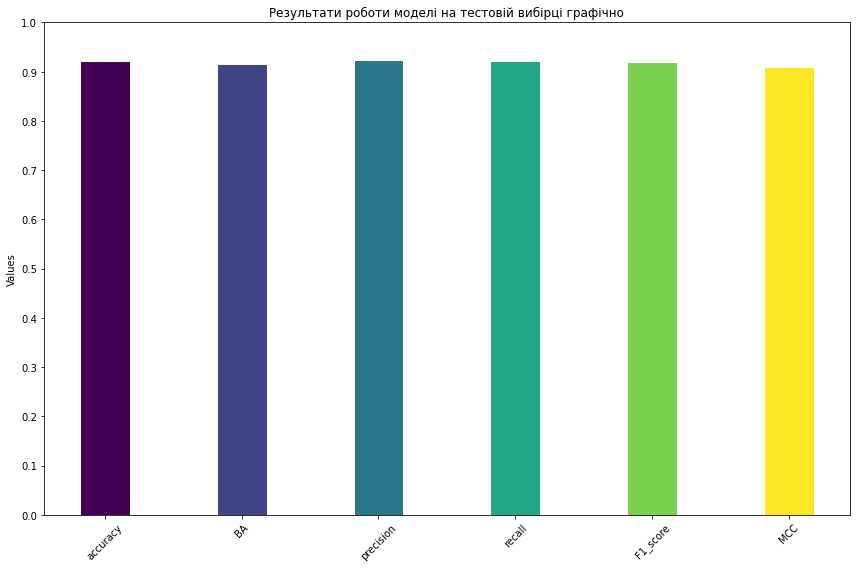

In [326]:
plot_metrics(test_metrics, names, 'Результати роботи моделі на тестовій вибірці графічно')

### 7. З'ясувати вплив степеня метрики Мінковського (від 1 до 20) на результати класифікації. Результати представити графічно.

In [ ]:
iters = 20

In [327]:
train_results = []
test_results = []

In [328]:
for i in tqdm(range(1, iters+1)):
    kNN = KNeighborsClassifier(p=i)
    
    kNN.fit(X_train, y_train)
    
    trm, _ = calc_metrics(kNN, X_train, y_train, test=False, output=False)
    tsm, _ = calc_metrics(kNN, X_test, y_test, test=True, output=False)
    
    train_results.append(trm)
    test_results.append(tsm)

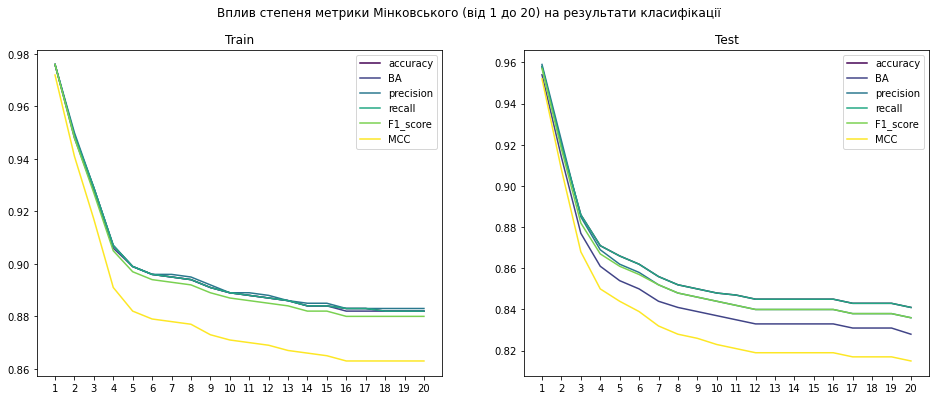

In [350]:
plot_results(train_results, test_results, names, 'Вплив степеня метрики Мінковського (від 1 до 20) на результати класифікації')